# Data Mining Team Project
Credit Score

### Loading Data Set
csv로부터 데이터 로드, 두 개의 sheet merge 완료

In [7]:
import pandas as pd
applications = pd.read_csv('./credit_dataset/application_record.csv')
#applications #438557 rows × 18 columns

In [8]:
credits = pd.read_csv('./credit_dataset/credit_record.csv')
#credits 

In [9]:
df = pd.merge(applications, credits, on = 'ID', how = 'inner') #application record 수가 더 적어 inner join

In [13]:
#df.info() #777715 rows × 20 columns

In [14]:
df.isnull().sum() #occupation_type에 240048개의 Null 값 확인

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64

### Data Sampling 
- 필요없는 Data 제거 (FLAG_MOBIL)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

### Data Transform
`DAYS_EMPLOYED` : Count backwards from current day(0). If positive, it means the person currently unemployed.   

`DAYS_BIRTH`: Count backwards from current day (0), -1 means yesterday  

`Account Length` 라는 column 생성
- month balance를 바탕으로 각 ID에 대한 account_length 로 활용

In [9]:
df['AGE_YEARS']=round(-df['DAYS_BIRTH']/365.2425,0)

df['FLAG_WORK_PHONE'].value_counts()


FLAG_WORK_PHONE
0    597427
1    180288
Name: count, dtype: int64

In [12]:
df['FLAG_EMAIL'].value_counts()

FLAG_EMAIL
0    706418
1     71297
Name: count, dtype: int64

In [180]:
df['DAYS_EMPLOYED'].describe() # 현재 unemployed된 사람의 값이 쓰레기값으로 나옴.

count    777715.000000
mean      57775.825016
std      136471.735391
min      -15713.000000
25%       -3292.000000
50%       -1682.000000
75%        -431.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [181]:
df['DAYS_EMPLOYED'].replace(365243,0,inplace=True)
df[df['DAYS_EMPLOYED']>=0]['DAYS_EMPLOYED'].value_counts() #더 이상 양수값 없음.

DAYS_EMPLOYED
0    127972
Name: count, dtype: int64

In [182]:
df['YEARS_EMPLOYED']=round(-df['DAYS_EMPLOYED']/365.2425)
df.loc[df['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0 # 0 이하의 값들 0으로 처리

In [183]:
# 변환완료되어 기존 열 drop
df.drop(columns=["DAYS_BIRTH","DAYS_EMPLOYED"],inplace=True)

In [184]:
account_length_df = pd.DataFrame(df.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()
account_length_df.rename(columns={'MONTHS_BALANCE': 'ACCOUNT_LENGTH'}, inplace=True)
account_length_df['ACCOUNT_LENGTH'] = -account_length_df['ACCOUNT_LENGTH']

In [185]:
account_length_df.describe() #account length의 min = 0, max = 60

,ID,ACCOUNT_LENGTH
count,3.645700e+04,36457.000000
mean,5.078227e+06,26.164193
std,4.187524e+04,16.501854
min,5.008804e+06,0.000000
25%,5.042028e+06,12.000000
50%,5.074614e+06,24.000000
75%,5.115396e+06,39.000000
max,5.150487e+06,60.000000


In [74]:
df = pd.merge(df, account_length_df, how='inner', on=['ID'])

### Data Scaling 
- AMT_INCOME_TOTAL
- CNT_CHILDREN
- YEARS_EMPLOYED
- CNT_FAM_MEMBERS

In [186]:
cols_to_scale = ['AMT_INCOME_TOTAL', 'CNT_CHILDREN','YEARS_EMPLOYED','CNT_FAM_MEMBERS']
for col in cols_to_scale:
    print(df[col].describe().round(),'\n')
# 평균 연봉 2억, 최소 3천인데? 왜케 잘살아ㅋㅋ ㅠ

count     777715.0
mean      188535.0
std       101622.0
min        27000.0
25%       121500.0
50%       162000.0
75%       225000.0
max      1575000.0
Name: AMT_INCOME_TOTAL, dtype: float64 

count    777715.0
mean          0.0
std           1.0
min           0.0
25%           0.0
50%           0.0
75%           1.0
max          19.0
Name: CNT_CHILDREN, dtype: float64 

count    777715.0
mean          6.0
std           7.0
min           0.0
25%           1.0
50%           5.0
75%           9.0
max          43.0
Name: YEARS_EMPLOYED, dtype: float64 

count    777715.0
mean          2.0
std           1.0
min           1.0
25%           2.0
50%           2.0
75%           3.0
max          20.0
Name: CNT_FAM_MEMBERS, dtype: float64 



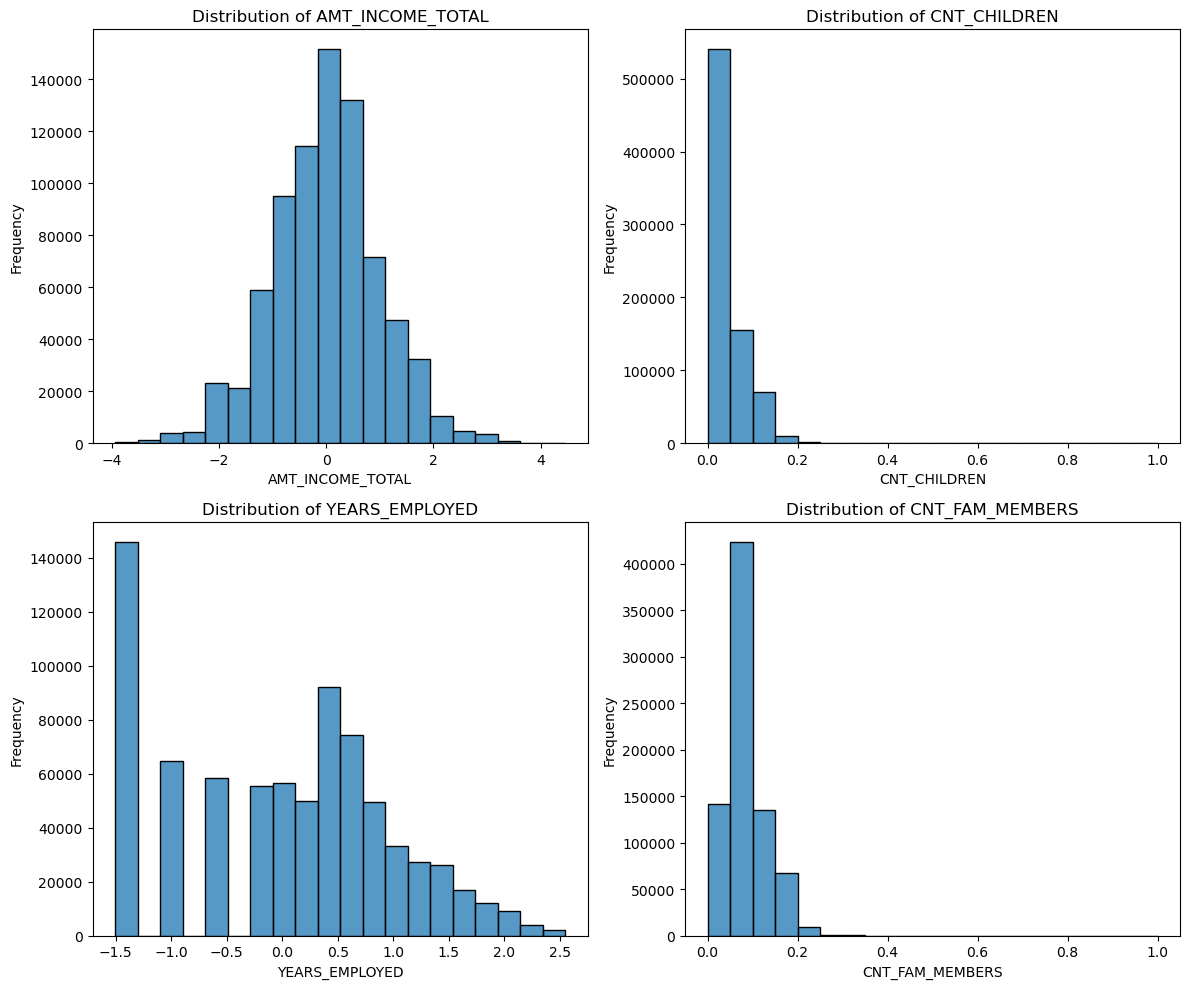

In [192]:
# 2x2 그리드에서 서브플롯 생성 -> GPT ㄱㅅ
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for col, ax in zip(cols_to_scale, axes.flatten()):
    sns.histplot(df[col], bins=20, ax=ax) 
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# 레이아웃 조정
plt.tight_layout()
plt.show()

In [189]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

power_scaler=PowerTransformer()
minmax_scaler = MinMaxScaler()

#min-max scaling
columns_to_scale = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS']
df[columns_to_scale] = minmax_scaler.fit_transform(df[columns_to_scale])
df[columns_to_scale]

,CNT_CHILDREN,CNT_FAM_MEMBERS
0,0.0,0.052632
1,0.0,0.052632
2,0.0,0.052632
3,0.0,0.052632
4,0.0,0.052632
...,...,...
777710,0.0,0.000000
777711,0.0,0.000000
777712,0.0,0.000000
777713,0.0,0.000000


In [ ]:
#power scalingo

columns_to_scale = ['AMT_INCOME_TOTAL','YEARS_EMPLOYED']
df[columns_to_scale] = power_scaler.fit_transform(df[columns_to_scale])
df[columns_to_scale]

### STATUS preprocessing

In [32]:
# for 확인
filtered_ids = df.groupby('ID')['STATUS'].transform(lambda x: all(y in ['C', 'X'] for y in x))
filtered_df = df[filtered_ids]
filtered_df['STATUS'].value_counts() #ID 개수는 4455, record 수는 93665

STATUS
X    75005
C    18660
Name: count, dtype: int64

In [53]:
# STATUS가 모두 C or X인 ID의 record 삭제 -> df_filtered 생성 (약 10만개의 record 제거)
id_to_remove = df.groupby('ID').filter(lambda x: all(y in ['C', 'X'] for y in x['STATUS']))['ID'].unique()
df_filtered = df[~df['ID'].isin(id_to_remove)]
df_filtered

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,inoccupation,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,inoccupation,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,inoccupation,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,inoccupation,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,inoccupation,2.0,-4,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-9,0
777711,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-10,2
777712,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-11,1
777713,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-12,0


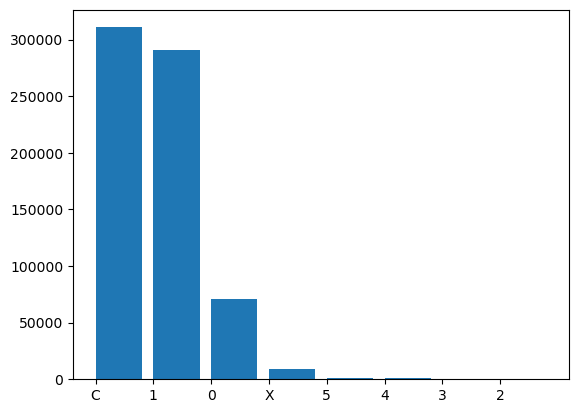

In [100]:
import matplotlib.pyplot as plt

# 각 status별 개수. C와 1이 너무 압도적인데? 이정도면 나머지가 outlier 취급될듯.
t = df_filtered['STATUS'].unique()
s = df_filtered['STATUS'].value_counts()
_ = plt.bar(t, s, align= 'edge') # align : bar와 눈금 간의 정렬 조정. edge 등등..

### 각 column별 unique 값 확인

그냥 확인하려고...
- 중간에 occupation NaN-> inoccupation 으로 변환해서 결측치 제거 

In [15]:
def category_check(type):
    print(type,':', applications[type].unique(),'\n')

for i in df.columns[6:10]:
    category_check(i)

NAME_INCOME_TYPE : ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student'] 

NAME_EDUCATION_TYPE : ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree'] 

NAME_FAMILY_STATUS : ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow'] 

NAME_HOUSING_TYPE : ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment'] 



In [16]:
#flag category 중 object 확인 -> one-hot encoding으로 바꿀까?
print('FLAG_OWN_CAR: ', df['FLAG_OWN_CAR'].unique(),'\n')
print('FLAG_OWN_REALTY: ', df['FLAG_OWN_REALTY'].unique(),'\n')

def count_check(type):
    print(type,':', df[type].value_counts(dropna=False),'\n')

for i in df.columns[12:17]:
     count_check(i)

FLAG_OWN_CAR:  ['Y' 'N'] 

FLAG_OWN_REALTY:  ['Y' 'N'] 

FLAG_MOBIL : FLAG_MOBIL
1    777715
Name: count, dtype: int64 

FLAG_WORK_PHONE : FLAG_WORK_PHONE
0    597427
1    180288
Name: count, dtype: int64 

FLAG_PHONE : FLAG_PHONE
0    543650
1    234065
Name: count, dtype: int64 

FLAG_EMAIL : FLAG_EMAIL
0    706418
1     71297
Name: count, dtype: int64 

OCCUPATION_TYPE : OCCUPATION_TYPE
NaN                      240048
Laborers                 131572
Core staff                77112
Sales staff               70362
Managers                  67738
Drivers                   47678
High skill tech staff     31768
Accountants               27223
Medicine staff            26691
Cooking staff             13416
Security staff            12400
Cleaning staff            11399
Private service staff      6714
Low-skill Laborers         3623
Secretaries                3149
Waiters/barmen staff       2557
HR staff                   1686
IT staff                   1319
Realty agents              1260

In [19]:
#occupation에 NaN이 무직을 의미하는 듯하다. 다른 무직 관련 카테고리가 없다. NaN으로 남겨두면 안될 것 같으니 채워주자.
#df['OCCUPATION_TYPE'].fillna('inoccupation', inplace=True)
df['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
inoccupation             240048
Laborers                 131572
Core staff                77112
Sales staff               70362
Managers                  67738
Drivers                   47678
High skill tech staff     31768
Accountants               27223
Medicine staff            26691
Cooking staff             13416
Security staff            12400
Cleaning staff            11399
Private service staff      6714
Low-skill Laborers         3623
Secretaries                3149
Waiters/barmen staff       2557
HR staff                   1686
IT staff                   1319
Realty agents              1260
Name: count, dtype: int64

In [20]:
df['MONTHS_BALANCE'].unique() #0~ 60 

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60])

In [77]:
# Get numerical column names
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Columns:")
print(num_cols)

# Get categorical column names
cat_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Columns:")
print(cat_cols)

Numerical Columns:
Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'ACCOUNT_LENGTH'],
      dtype='object')

Categorical Columns:
Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'STATUS'],
      dtype='object')


In [76]:
df['STATUS'].value_counts() #대출 상환이 가능한지의 여부를 따지는거면 적어

STATUS
C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: count, dtype: int64

# 추가 논의사항
- encoding 형태 어떻게 할건지?
- status 어떻게 할건지?

# 스근하게 모델 돌려보기...가 아니라 타겟 value 없어서 미루겠슴니다.


### Logistic Regression

In [ ]:
#EDA (1) 
#데이터셋을 통한 상관관계 분석으로 인사이트
#경영직무에 필요한.. 
#시각화나 measure, clustering 
#책임: 특이한 인사이트, 납득할 만한 인사이트, 시각화

#예측 (1)
#전처리 + 잘 맞는 방법론
#돌리는건.. 전처리를 얼마나 잘했냐??

#성능이 보장된. ->모델에 따른 성능 / 전처리나 target feature에 따른 성능

#feature 영향 어떻게 미치는지 찾기 어렵지 않을까? 
#개인에게 어차피 안알려주는 부분이니까.